## Импорт библиотек и настройка путей

In [2]:
# Импорт библиотек
import pandas as pd
import numpy as np
from pathlib import Path
import os
import matplotlib.pyplot as plt
import seaborn as sns

# Настройки отображения
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_colwidth', 30)
pd.options.display.float_format = '{:.2f}'.format

# Инициализация путей
root = Path(os.getcwd()).parent.parent
data_in = root / 'data' / 'processed_data'
data_out = root / 'data' / 'eda_data'

print("Пути инициализированы:")
print(f"Processed data: {data_in}")
print(f"EDA data: {data_out}")

Пути инициализированы:
Processed data: /Users/aleksey.sushchikh/Desktop/GitHub/MIFIHackatonSberAutoSubscriptionAnalysis/data/processed_data
EDA data: /Users/aleksey.sushchikh/Desktop/GitHub/MIFIHackatonSberAutoSubscriptionAnalysis/data/eda_data


## Загрузка данных

In [4]:
# Загрузка данных
print("\nЗагружаем предобработанные данные...")
data = pd.read_pickle(data_in / 'data_processed.pkl')
print("\nДанные успешно загружены!")


Загружаем предобработанные данные...

Данные успешно загружены!


## Первичный анализ данных

In [8]:
 def generate_summary(df: pd.DataFrame, name: str, sample_size: int = 3) -> None:
    """Генерация расширенной сводки по данным примерами"""
    print(f"\n{'='*50} {name.upper()} {'='*50}")
    print(f"Общее количество записей: {df.shape[0]:,}")
    print(f"Количество признаков: {df.shape[1]}")
    
    # Типы данных
    print("\nТипы данных:")
    print(df.dtypes.value_counts().rename('count').to_frame())
    
    # Пропуски
    missing = df.isna().sum().sort_values(ascending=False)
    missing_pct = (missing / df.shape[0] * 100).round(2)
    missing_df = pd.concat([missing, missing_pct], axis=1, keys=['count', '%']).query('count > 0')
    if not missing_df.empty:
        print("\nПропущенные значения:")
        print(missing_df)
    else:
        print("\nПропущенных значений нет")
        
    # Дубликаты
    dupes = df.duplicated().sum()
    print(f"\nДубликаты: {dupes} ({dupes/df.shape[0]*100:.2f}%)")
    
    # Примеры
    print(f"\nПервые {sample_size} записей:")
    display(df.head(sample_size))


def analyze_column(df: pd.DataFrame, col: str, max_display: int = 50) -> None:
    """Полный анализ колонки с выводом всех уникальных значений"""
    print(f"\n{'-'*60}")
    print(f"Полный анализ колонки: {col}")
    
    # Проверка существования колонки
    if col not in df.columns:
        print(f"Колонка {col} не найдена!")
        return
    
    # Пропуски
    na_count = df[col].isna().sum()
    print(f"Пропуски: {na_count} ({na_count/len(df)*100:.1f}%)")

    # Количество уникальных значений
    unique_count = df[col].nunique(dropna=False)
    print(f"Уникальных значений: {unique_count}")
    
    # Вывод всех значений для категориальных данных
    if unique_count <= max_display:
        print("\nВсе значения:")
        print(df[col].unique())
    else:
        print(f"\nСлишком много значений (> {max_display}). Примеры:")
        print(df[col].dropna().sample(10).unique())
        
    # Частотный анализ для числовых колонок
    if pd.api.types.is_numeric_dtype(df[col]):
        print("\nОписательная статистика:")
        print(df[col].describe())
    else:
        print("\nТоп-10 значений:")
        print(df[col].value_counts(dropna=False).head(20))


generate_summary(data, "Подготовленные данные к EDA")
for col in data.columns:
    analyze_column(data, col, max_display=100)
        


================================================== ПОДГОТОВЛЕННЫЕ ДАННЫЕ К EDA ==================================================
Общее количество записей: 1,860,042
Количество признаков: 38

Типы данных:
                count
float64            10
int64               9
object              3
int32               2
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
category            1
datetime64[ns]      1
category            1
category            1
category            1
category            1

Пропущенные значения:
               count    %
screen_width       8 0.00
screen_height      8 0.00

Дубликаты: 0 (0.00%)

Первые 3 записей:


,session_id,client_id,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_browser,geo_country,geo_city,session_start,visit_weekday,visit_hour,timeofday,is_weekend,traffic_type,geo_city_group,is_first_visit,log_visit_number,is_mobile,screen_width,screen_height,session_duration_sec,num_hits,num_target_events,num_unique_pages,max_hit_number,avg_time_between,log_session_duration_sec,log_num_hits,log_num_target_events,log_num_unique_pages,log_max_hit_number,log_avg_time_between
0,9055434745589932991.163775...,2108382700.1637753791,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Zlatoust,2021-11-24 14:36:32,2,14,afternoon,0,other,other,1,0.69,1,360.00,720.00,42927,2,0,1,4,42927.00,10.67,1.10,0.00,0.69,1.61,10.67
1,905544597018549464.1636867...,210838531.1636867288,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,Samsung Internet,Russia,Moscow,2021-11-14 08:21:30,6,8,morning,1,paid,Moscow,1,0.69,1,385.00,854.00,0,1,0,1,3,0.00,0.00,0.69,0.00,0.69,1.39,0.00
2,9055446045651783499.164064...,2108385331.1640648523,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,Chrome,Russia,Krasnoyarsk,2021-12-28 02:42:06,1,2,night,0,other,Krasnoyarsk,1,0.69,1,360.00,720.00,81336,7,0,2,11,13556.00,11.31,2.08,0.00,1.10,2.48,9.51



------------------------------------------------------------
Полный анализ колонки: session_id
Пропуски: 0 (0.0%)
Уникальных значений: 1860042

Слишком много значений (> 100). Примеры:
['491463535830462865.1639762340.1639762340'
 '6218307155189905452.1633499183.1633499183'
 '4716128212961741768.1623739339.1623739339'
 '2457020636985201069.1632539053.1632539053'
 '4323383608719705378.1635517731.1635517731'
 '1690746459322185612.1629878156.1629878156'
 '4094112984530193819.1631364853.1631364853'
 '6730156201906890035.1636656401.1636656401'
 '7801880791440331742.1639879648.1639879648'
 '9004274521073920277.1622581097.1622581097']

Топ-10 значений:
session_id
9055434745589932991.1637753792.1637753792    1
6294640354816492625.1638728787.1638728809    1
6294832296889291185.1623245519.1623245519    1
6294832296889291185.1623161065.1623161065    1
6294832296889291185.1623156608.1623156608    1
6294832296889291185.1623069105.1623069105    1
6294825034110946181.1634421637.1634421637    1
629481

## Распределение целевой переменной

Conversion Rate: 0.37%


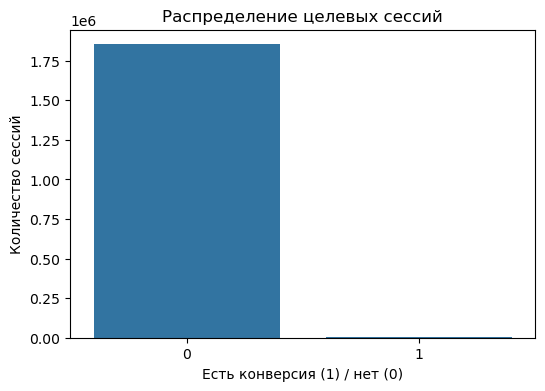

In [10]:
# Доля конверсий
data['converted'] = (data['num_target_events'] > 0).astype(int)
cr = data['converted'].mean()
print(f"Conversion Rate: {cr:.2%}")

# Гистограмма распределения
plt.figure(figsize=(6,4))
sns.countplot(x='converted', data=data)
plt.title('Распределение целевых сессий')
plt.xlabel('Есть конверсия (1) / нет (0)')
plt.ylabel('Количество сессий')
plt.show()

## Числовые признаки

In [ ]:
num_cols = ['session_duration_sec','num_hits','num_unique_pages','visit_hour']
for col in num_cols:
    fig, axes = plt.subplots(1, 2, figsize=(12,4))
    sns.histplot(data[col], ax=axes[0], kde=True)
    axes[0].set_title(f'Гистограмма {col}')
    sns.boxplot(x=data[col], ax=axes[1])
    axes[1].set_title(f'Box‑plot {col}')
    plt.tight_layout()
    plt.show()


## Категориальные признаки

In [ ]:
cat_col = 'device_category'
top = data[cat_col].value_counts().index

plt.figure(figsize=(8,4))
sns.countplot(x=cat_col, data=data, order=top)
plt.title(f'Распределение {cat_col}')
plt.show()

# CR по категориям
cr_by_cat = data.groupby(cat_col)['converted'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x=cat_col, y='converted', data=cr_by_cat, order=top)
plt.title(f'Conversion Rate по {cat_col}')
plt.ylabel('CR')
plt.show()

## Число и среднее число событий

In [ ]:
for col in ['num_hits','session_duration_sec']:
    plt.figure(figsize=(6,4))
    sns.kdeplot(data=data, x=col, hue='converted', common_norm=False)
    plt.title(f'{col}: конверсия vs не конверсия')
    plt.show()

## Heatmap корреляций числовых фич

In [ ]:
num_feats = ['visit_hour','session_duration_sec','num_hits','num_unique_pages','log_visit_number']
corr = data[num_feats + ['converted']].corr()
plt.figure(figsize=(8,6))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Корреляционная матрица')
plt.show()

## Парные графики (Pairplot)

In [ ]:
sns.pairplot(
    data[num_feats + ['converted']].sample(5000), 
    hue='converted',
    corner=True
)
plt.show()

## Распределение по часам и дням недели

In [ ]:
# CR по часам
hourly = data.groupby('visit_hour')['converted'].mean().reset_index()
plt.figure(figsize=(10,4))
sns.lineplot(x='visit_hour', y='converted', data=hourly, marker='o')
plt.title('CR по часам дня')
plt.ylabel('CR')
plt.show()

# CR по дням недели
weekday = data.groupby('visit_weekday')['converted'].mean().reset_index()
plt.figure(figsize=(8,4))
sns.barplot(x='visit_weekday', y='converted', data=weekday)
plt.title('CR по дню недели')
plt.xlabel('0=Пн … 6=Вс')
plt.ylabel('CR')
plt.show()